# Import needed Libraries

In [7]:
import math
from random import sample
from sklearn import linear_model
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import deepcopy
import seaborn as sns
from tabulate import tabulate

Here we have imported the needed methods and libraries that we used in training models and they are:
- math: import `log10` method in order to use it in normalizing the data using scaling technique
- random: import `sample` method in order to split data randomly into training and testing sets
- sklearn: import `linear_model` the model of linear regression to use it in training
- numpy: the known library for matrix manipulation. 
- pandas: the known library for using files.
- copy: to copy an instance of the data
- seaborn: for ploting boxplot 


# Reading and manipulating data

## Reading the data
Here we have read the data from a Comma Separated Values files (CSV) using pandas library.

In [136]:
data = pd.read_csv('grades.csv')
data

,HW1,HW2,Midterm,Project,Final
0,0,78,32,87,71
1,0,37,25,91,48
2,63,100,34,92,59
3,70,93,35,92,64
4,50,75,20,76,42
5,43,0,26,55,54
6,0,47,22,0,37
7,47,80,26,94,56
8,97,97,30,92,60
9,50,67,21,76,38


## Manipulating the data
Here we want to process the data in order to use it in model training, frist we want to rpleace all zeros in each cell the the average of the same column.

In [137]:
def clean_data(data):
    for parameter in data.columns:
        temp = np.array(data[parameter])
        # Compute the median of the non-zero elements
        m = np.mean(temp[temp > 0])
        # Assign the median to the zero elements 
        temp[temp == 0] = m
        data[parameter] = temp
    return data
data = clean_data(data)
data

,HW1,HW2,Midterm,Project,Final
0,66,78,32,87,71
1,66,37,25,91,48
2,63,100,34,92,59
3,70,93,35,92,64
4,50,75,20,76,42
5,43,82,26,55,54
6,66,47,22,85,37
7,47,80,26,94,56
8,97,97,30,92,60
9,50,67,21,76,38


## Choosing parameters and Splitting the data
Here we want to split the data with choosing the best paramters for linear training by getting the parameters with correlation larger than 0.8. So we need to visualize the all parameters with `Final` label.

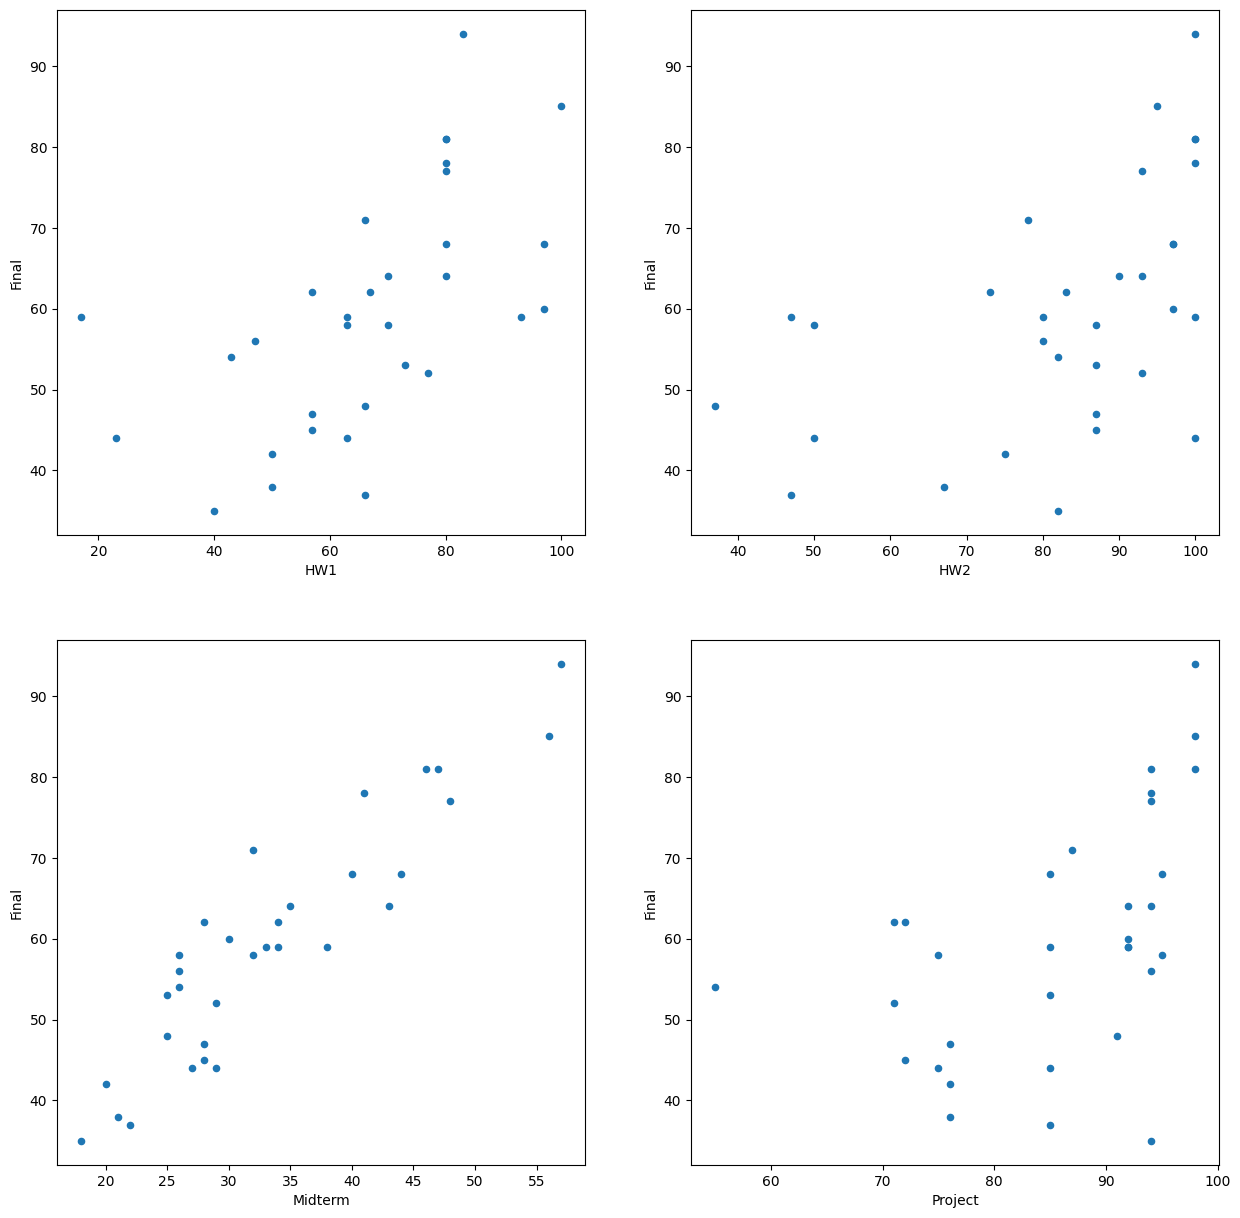

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
count = 0

for parameter in data.columns:
        if parameter != 'Final':
            data.plot(kind='scatter', x=parameter, y='Final',ax=axes[count//2,count%2]);
            count+=1

After seeing the plots, we can cleary see that `Midterm` label has the closest correlation with `Final`. So, we must choose it for training. But before that we must clean the data from the outliers, so we have used boxplots to identify outliers as shown Below:

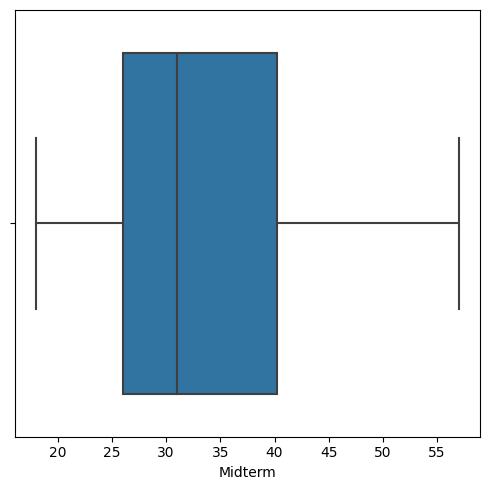

In [139]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5, 5))
ax = sns.boxplot(x=data['Midterm'])
fig.tight_layout()

The boxplot shows that values below 18 and above 57 are probably outliers so there is no outliers on our data.
`data_to_train` below chooses the best parameters and splits data randomly but before that we must normalize the data.

In [140]:
def parameters_reduction(data):
    headers = data.columns
    used = []
    data['constant'] = 1
    for parameter in headers:
        if data[parameter].corr(data['Final']) > 0.8:
            if parameter not in used:
                used.append(parameter)
    used.append('constant')
    data = data[used]
    data = data[(data['Midterm'] > 18) & (data['Midterm'] < 57)]
    return data

data = parameters_reduction(data)
data

,Midterm,Final,constant
0,32,71,1
1,25,48,1
2,34,59,1
3,35,64,1
4,20,42,1
5,26,54,1
6,22,37,1
7,26,56,1
8,30,60,1
9,21,38,1


We can normalize the data with different ways, the most known 3 techniques are:
- min-max: $$v' = {(v - min_A)\over (max_A - min_A)}{(new\_max_A - new\_min_A}) + new\_min_A$$
- Z-score: $$v' = {{(v - mean_a)}\over (variance_a)}$$
- Scaling: $$v' = {v \over 10^j}$$
Here we are gonna try the  Z-score model So we have this dataset:

In [141]:
def normal_z_score(temp_data):
    for parameter in temp_data.columns:
        if parameter != 'Final' and parameter != 'constant':
            temp_data[parameter] = (temp_data[parameter] - temp_data[parameter].mean()) / temp_data[parameter].std()
    return temp_data


def normal_min_max(temp_data):
    for parameter in temp_data.columns:
        if parameter != 'Final' and parameter != 'constant':
            temp_data[parameter] = (temp_data[parameter] - temp_data[parameter].min()) / (temp_data[parameter].max() - temp_data[parameter].min())

    return temp_data


def normal_scale_data(data):
    for parameter in data.columns:
        if parameter != 'Final' and parameter != 'constant':
            data[parameter] = data[parameter] / pow(10, int(math.log10(max(data[parameter]))))
    return data

temp_data = deepcopy(data)
data_z_score = normal_z_score(temp_data)

As we can see below, the three datasets have different numeric values due to the normalization

In [142]:
data_z_score

,Midterm,Final,constant
0,-0.122282,71,1
1,-0.900441,48,1
2,0.100049,59,1
3,0.211215,64,1
4,-1.456269,42,1
5,-0.789275,54,1
6,-1.233938,37,1
7,-0.789275,56,1
8,-0.344613,60,1
9,-1.345103,38,1


Now we need to split data randomly for training and testing. We can see the method below:

In [143]:
def split_data(data):
    
    training = data.iloc[sample(range(0, len(data)), int(len(data) * 0.8))]
    used = training.columns.drop('Final')
    testing = data.drop(training.index)
    training = training.reset_index(drop=True)
    testing = testing.reset_index(drop=True)

    training_data = training[used]
    training_y = training['Final']
    test_data = testing[used]
    test_y = testing['Final']
    return training_data, training_y, test_data, test_y
    
training_data, training_y, test_data, test_y = split_data(data_z_score)

Now we will use these sets on linear regression training, we will train using the three methods ans then compare them.

In [144]:
 def linear_regression_closed_form(training_data, training_y, test_data, test_y):
        x = np.array(training_data)
        xt = np.transpose(x)
        xtx = np.dot(xt, x)
        xtx = xtx + np.identity(len(xtx)) * 0.0001 #Regularization 
        w = np.linalg.inv(np.dot(xt, x))
        w = np.dot(w, xt)
        w = np.dot(w, np.array(training_y))
        y = np.dot(test_data, w)
        u = (y - test_y) ** 2
        u = np.sum(u)
        v = (test_y - test_y.mean()) ** 2
        v = np.sum(v)
        r2 = 1 - u / v
        
        return w, r2, u

In [145]:
model_closed_form= list(linear_regression_closed_form(training_data, training_y, test_data, test_y))
model_closed_form.insert(0,"Closed Form")

In [146]:
def linear_regression_gradient_descent(training_data, training_y, test_data, test_y, learning_rate, iterations):
    x = np.array(training_data)
    xt = np.transpose(x)
    w = np.zeros(len(xt))
    for i in range(iterations):
        y = np.dot(x, w)
        u = y - training_y
        u = np.dot(u, x)
        w = w - learning_rate * u
    y = np.dot(test_data, w)
    u = (y - test_y) ** 2
    u = np.sum(u)
    v = (test_y - test_y.mean()) ** 2
    v = np.sum(v)
    r2 = 1 - u / v
    return w, r2,u

In [147]:
model_gradient_descent_100 = list(linear_regression_gradient_descent(training_data, training_y, test_data, test_y, 0.001, 100))
model_gradient_descent_100.insert(0,"Gradient Descent 100 iterations")
model_gradient_descent_200 = list(linear_regression_gradient_descent(training_data, training_y, test_data, test_y, 0.001, 200))
model_gradient_descent_200.insert(0,"Gradient Descent 200 iterations")
model_gradient_descent_500 = list(linear_regression_gradient_descent(training_data, training_y, test_data, test_y, 0.001, 500))
model_gradient_descent_500.insert(0,"Gradient Descent 500 iterations")


In [148]:
def linear_regression_lib(training_data, training_y, test_data, test_y):
    linear = linear_model.LinearRegression()
    linear.fit(training_data, training_y)
    y = linear.predict(test_data)
    u = (y - test_y) ** 2
    u = np.sum(u)
    v = (test_y - test_y.mean()) ** 2
    v = np.sum(v)
    r2 = 1 - u / v
    w = [linear.coef_[0], linear.intercept_]
#     w = np.matrix(w)
    return w, r2, u


In [149]:
model_lib = list(linear_regression_lib(training_data, training_y, test_data, test_y))
model_lib.insert(0,"Library model")

#  Compare Models 

In [150]:
all_data = [model_closed_form,model_gradient_descent_100,model_gradient_descent_200,model_gradient_descent_500,model_lib]

In [152]:
head = ["Models","Weights", "Performance","Sum Of Square Error"]
 
print(tabulate(all_data, headers=head, tablefmt="pipe"))

| Models                          | Weights                                 |   Performance |   Sum Of Square Error |
|:--------------------------------|:----------------------------------------|--------------:|----------------------:|
| Closed Form                     | [10.81363895 59.33477298]               |      0.862813 |               173.13  |
| Gradient Descent 100 iterations | [11.07619412 54.19690847]               |      0.790773 |               264.045 |
| Gradient Descent 200 iterations | [10.96230333 58.86162396]               |      0.871416 |               162.273 |
| Gradient Descent 500 iterations | [10.81416385 59.3342394 ]               |      0.862838 |               173.099 |
| Library model                   | [10.813638952656985, 59.33477297895902] |      0.862813 |               173.13  |


From table above, we can see  that all models gave a high and very closed performance and SSE excpet gradient descent with small number of iterations so we can see the performance increased with increasing number of iterations. Down 4 plots for each model 

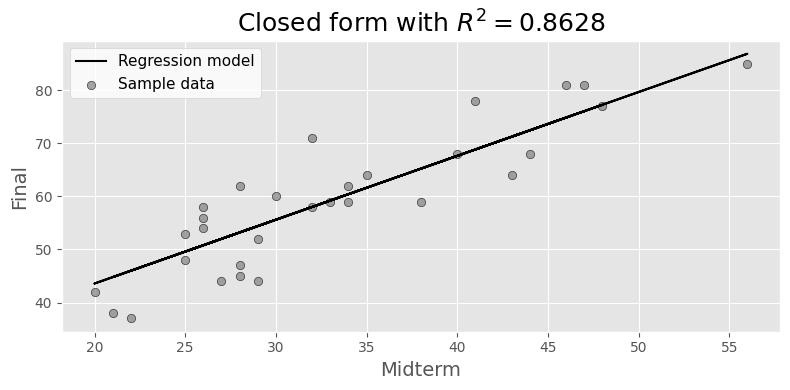

In [153]:
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

response = np.dot(data_z_score[["Midterm","constant"]], model_closed_form[1])

ax.plot(data['Midterm'], response, color='k', label='Regression model')

ax.scatter(data['Midterm'], data['Final'], edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Final', fontsize=14)
ax.set_xlabel('Midterm', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('Closed form with $R^2= %.4f$' % model_closed_form[2], fontsize=18)

fig.tight_layout()

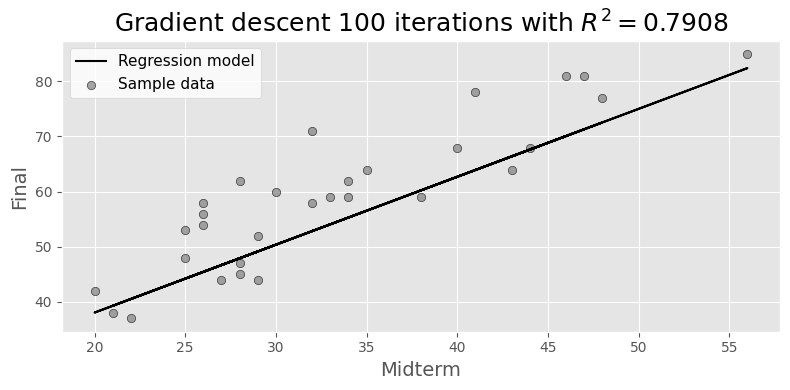

In [154]:
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
response = np.dot(data_z_score[["Midterm","constant"]], model_gradient_descent_100[1])

ax.plot(data['Midterm'], response, color='k', label='Regression model')

ax.scatter(data['Midterm'], data['Final'], edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Final', fontsize=14)
ax.set_xlabel('Midterm', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('Gradient descent 100 iterations with $R^2= %.4f$' % model_gradient_descent_100[2], fontsize=18)

fig.tight_layout()

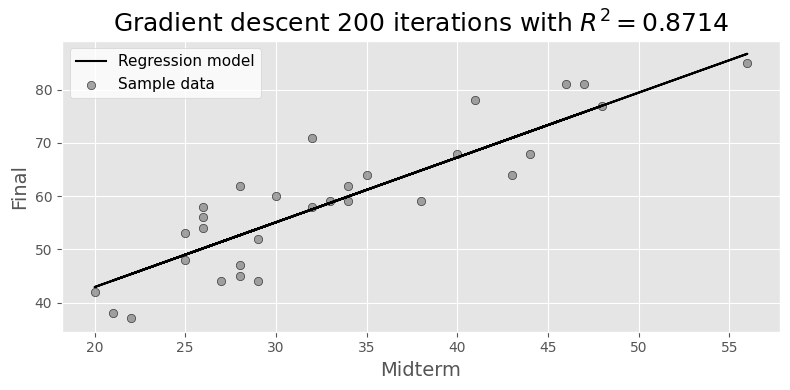

In [155]:
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
response = np.dot(data_z_score[["Midterm","constant"]], model_gradient_descent_200[1])

ax.plot(data['Midterm'], response, color='k', label='Regression model')

ax.scatter(data['Midterm'], data['Final'], edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Final', fontsize=14)
ax.set_xlabel('Midterm', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('Gradient descent 200 iterations with $R^2= %.4f$' % model_gradient_descent_200[2], fontsize=18)

fig.tight_layout()

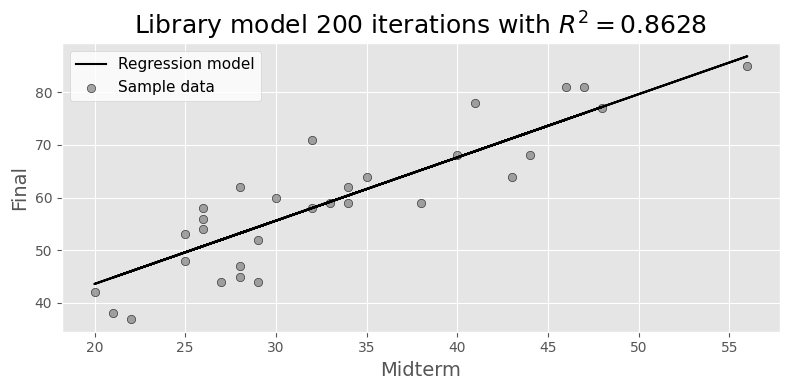

In [156]:
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
response = np.dot(data_z_score[["Midterm","constant"]], model_lib[1])

ax.plot(data['Midterm'], response, color='k', label='Regression model')

ax.scatter(data['Midterm'], data['Final'], edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Final', fontsize=14)
ax.set_xlabel('Midterm', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('Library model 200 iterations with $R^2= %.4f$' % model_lib[2], fontsize=18)

fig.tight_layout()

All models gave an acceptable performance, we can see that gradient descent gave a very close perfromance to the closed form model.